<a href="https://colab.research.google.com/github/WuKaiYi/AI-master.github.io/blob/master/%E3%80%8CToonify_yourself%E3%80%8D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toonify yourself!

Please ensure that you're using a GPU runtime

First some setup:

In [39]:
%tensorflow_version 1.x

In [40]:
!git clone https://github.com/justinpinkney/stylegan2
%cd stylegan2
!nvcc test_nvcc.cu -o test_nvcc -run

Cloning into 'stylegan2'...
remote: Enumerating objects: 269, done.
remote: Total 269 (delta 0), reused 0 (delta 0), pack-reused 269
Receiving objects: 100% (269/269), 2.31 MiB | 13.09 MiB/s, done.
Resolving deltas: 100% (143/143), done.
/content/stylegan2/stylegan2
CPU says hello.
GPU says hello.


In [41]:
!mkdir raw
!mkdir aligned
!mkdir generated

## Upload your own photos

Upload your photos to `raw/`. These don't need to be aligned as we'll use a face detector to grab all the faces and transform them into the correct format. One note of caution is that you'll need a pretty high-resolution picture of a face to get a sharp result (the final face crop is resized to 1024x1024 pixels)

We'll grab a example image from the internet to work with.

The basic process is:
- Extract faces and align the images
- Project the images (i.e. find the latent code)
- Toonify the images (i.e. use the latent code with the toon model)

Results will be placed in the stylegan2/generated folder

In [42]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1sJEpqidjHeDoRG7K0pH5B5RQ01F75d7H' -O raw/example.jpg

--2020-09-22 03:40:08--  https://docs.google.com/uc?export=download&id=1sJEpqidjHeDoRG7K0pH5B5RQ01F75d7H
Resolving docs.google.com (docs.google.com)... 74.125.129.138, 74.125.129.113, 74.125.129.100, ...
Connecting to docs.google.com (docs.google.com)|74.125.129.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-2c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7tteuu7k9turdns8krdsbhhpu3kst9d7/1600746000000/08847777860848455912/*/1sJEpqidjHeDoRG7K0pH5B5RQ01F75d7H?e=download [following]
--2020-09-22 03:40:08--  https://doc-04-2c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7tteuu7k9turdns8krdsbhhpu3kst9d7/1600746000000/08847777860848455912/*/1sJEpqidjHeDoRG7K0pH5B5RQ01F75d7H?e=download
Resolving doc-04-2c-docs.googleusercontent.com (doc-04-2c-docs.googleusercontent.com)... 108.177.112.132, 2607:f8b0:4001:c12::84
Connecting to doc-04-2c-docs.googleusercontent.com (doc-04-2c-

In [43]:
import pretrained_networks

# use my copy of the blended model to save Doron's download bandwidth
# get the original here https://mega.nz/folder/OtllzJwa#C947mCCdEfMCRTWnDcs4qw
blended_url = "https://drive.google.com/uc?id=1H73TfV5gQ9ot7slSed_l-lim9X7pMRiU" 
ffhq_url = "http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl"

_, _, Gs_blended = pretrained_networks.load_networks(blended_url)
_, _, Gs = pretrained_networks.load_networks(ffhq_url)

In [44]:
!python align_images.py raw aligned

In [45]:
!python project_images.py --num-steps 500 aligned generated

Loading networks from "http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.
Loading images from ".stylegan2-tmp/dataset/images"
detected 1 images ...
Creating dataset ".stylegan2-tmp/dataset/tfrecords"
Adding the images to tfrecords ...
added images 0
Added 1 images.
Projecting image "example_01.png"...


In [46]:
import numpy as np
from PIL import Image
import dnnlib
import dnnlib.tflib as tflib
from pathlib import Path

latent_dir = Path("generated")
latents = latent_dir.glob("*.npy")
for latent_file in latents:
  latent = np.load(latent_file)
  latent = np.expand_dims(latent,axis=0)
  synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=False), minibatch_size=8)
  images = Gs_blended.components.synthesis.run(latent, randomize_noise=False, **synthesis_kwargs)
  Image.fromarray(images.transpose((0,2,3,1))[0], 'RGB').save(latent_file.parent / (f"{latent_file.stem}-toon.jpg"))


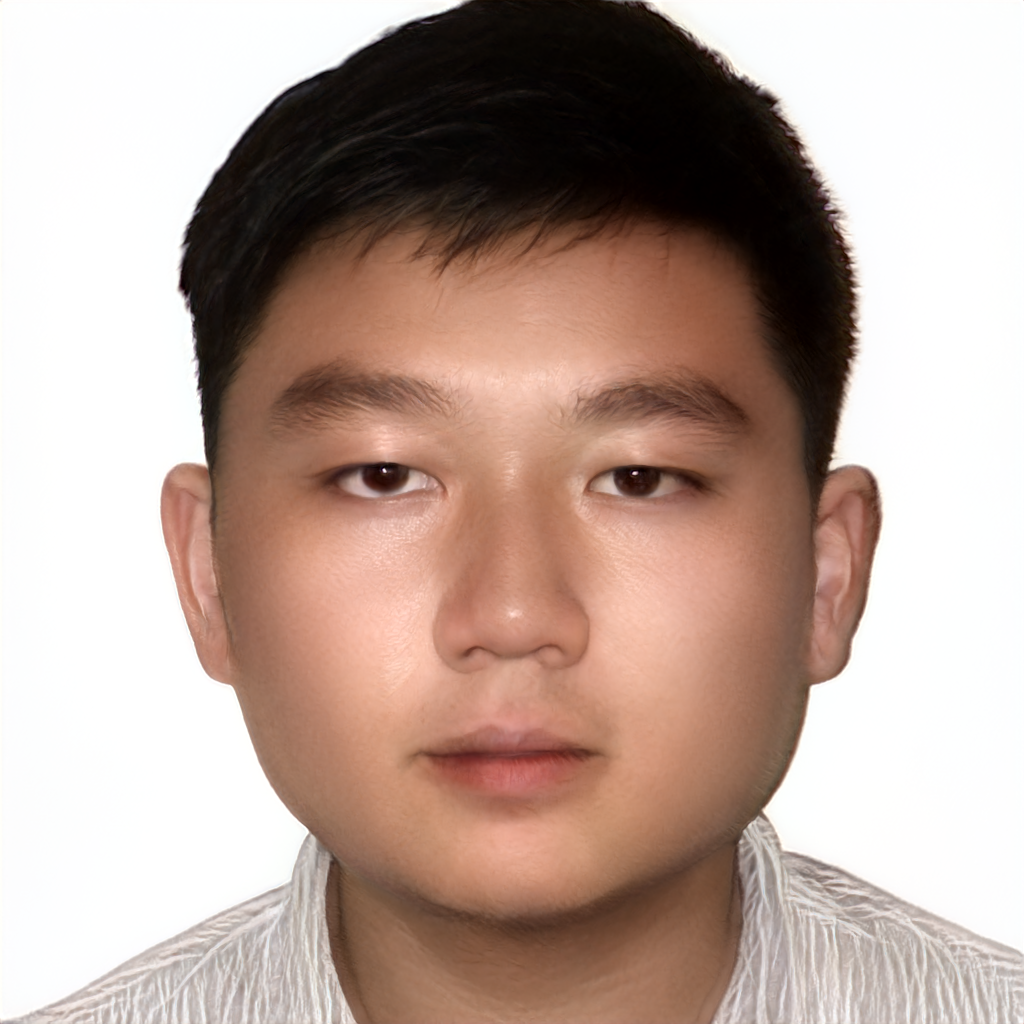

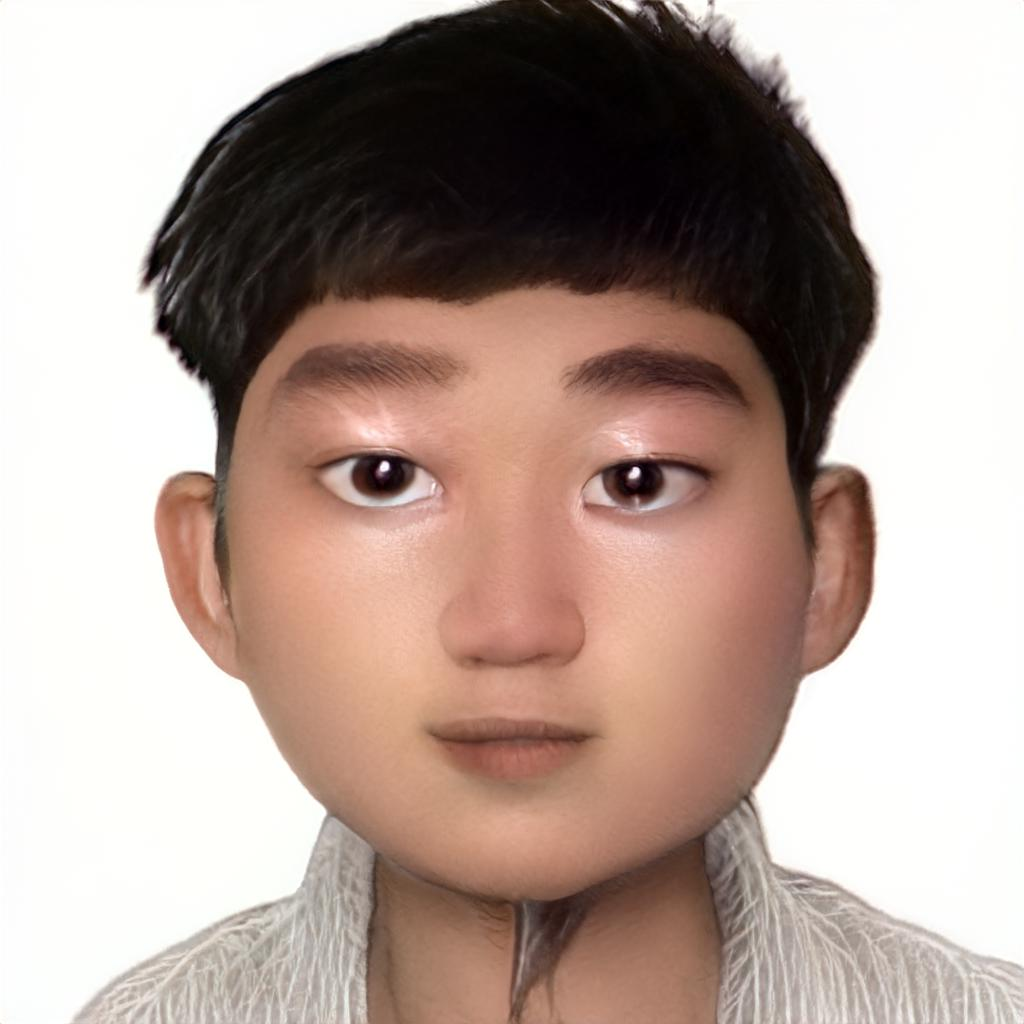

In [47]:
from IPython.display import Image 
embedded = Image(filename="generated/example_01.png", width=256)
display(embedded)
tooned = Image(filename="generated/example_01-toon.jpg", width=256)
display(tooned)